In [1]:
! pip install yfinance pandas numpy scikit-learn torch tqdm


[*********************100%***********************]  1 of 1 completed

Device: cuda



Training LSTM...

Epoch 1/40 - Loss:0.003122
Epoch 2/40 - Loss:0.000236
Epoch 3/40 - Loss:0.000155
Epoch 4/40 - Loss:0.000140
Epoch 5/40 - Loss:0.000139
Epoch 6/40 - Loss:0.000140
Epoch 7/40 - Loss:0.000139
Epoch 8/40 - Loss:0.000138
Epoch 9/40 - Loss:0.000138
Epoch 10/40 - Loss:0.000138
Epoch 11/40 - Loss:0.000138
Epoch 12/40 - Loss:0.000137
Epoch 13/40 - Loss:0.000137
Epoch 14/40 - Loss:0.000138
Epoch 15/40 - Loss:0.000137
Epoch 16/40 - Loss:0.000138
Epoch 17/40 - Loss:0.000137
Epoch 18/40 - Loss:0.000137
Epoch 19/40 - Loss:0.000138
Epoch 20/40 - Loss:0.000138
Epoch 21/40 - Loss:0.000137
Epoch 22/40 - Loss:0.000136
Epoch 23/40 - Loss:0.000138
Epoch 24/40 - Loss:0.000136
Epoch 25/40 - Loss:0.000136
Epoch 26/40 - Loss:0.000137
Epoch 27/40 - Loss:0.000137
Epoch 28/40 - Loss:0.000136
Epoch 29/40 - Loss:0.000136
Epoch 30/40 - Loss:0.000138
Epoch 31/40 - Loss:0.000136
Epoch 32/40 - Loss:0.000137
Epoch 33/40 - Loss:0.000139
Epoch 34/40 - Loss:0.000137
Epoch 35/40 - Loss:0.000136
Epoch 36/4

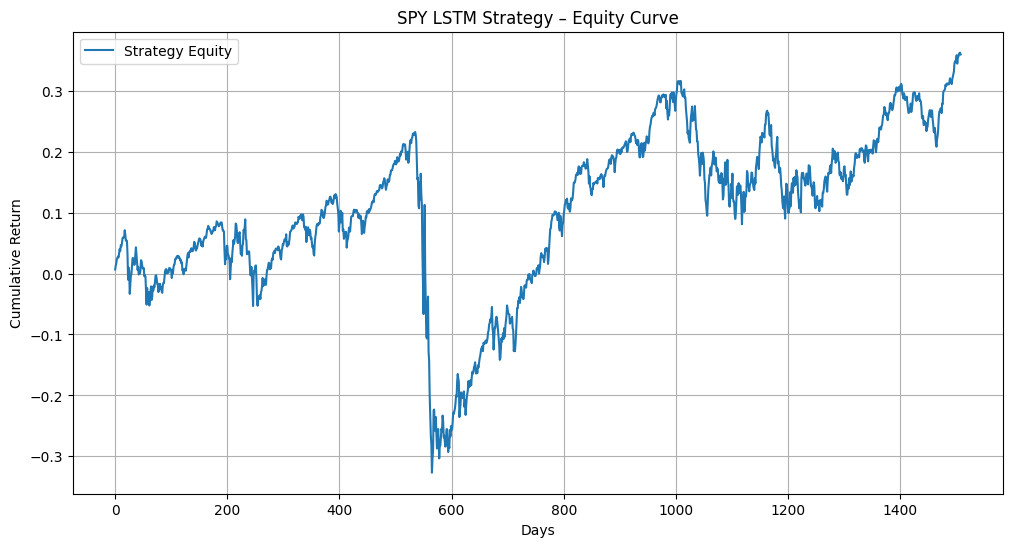


Saved backtest_results.csv



In [24]:
"""
This cell builds a complete LSTM-based trading pipeline for SPY.
It loads price data, creates 240-day lag sequences, trains an LSTM
to predict next-day returns, and runs a long/short backtest with
Sharpe, drawdown, win rate, and equity-curve reporting.
"""

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# CONFIG

TICKER = "SPY"
START = "1990-01-01"
END   = "2024-01-01"
M = 240             # number of daily lags
BATCH = 256
EPOCHS = 40
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)


#DOWNLOAD DATA
df = yf.download(TICKER, start=START, end=END)
df = df[["Open","Close"]].copy()
df["Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

#CREATE SEQUENCES
def create_sequences(df, m):
    X = []
    y = []

    rets = df["Return"].values

    for i in range(m, len(rets)-1):
        X.append(rets[i-m:i])
        y.append(rets[i+1])   # next-day return

    return np.array(X), np.array(y)

X, y = create_sequences(df, M)

# scale inputs
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1, M, 1)

# split train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# DATASET CLASS

class SPYDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_loader = DataLoader(SPYDataset(X_train,y_train), batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(SPYDataset(X_test,y_test), batch_size=BATCH)

# MODEL
class LSTMReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc   = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        return self.fc(out).squeeze(1)

model = LSTMReg().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# TRAINING LOOP
print("\nTraining LSTM...\n")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        opt.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss:{total_loss/len(train_loader):.6f}")


# PREDICT
model.eval()
preds = []
actual = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        p = model(Xb).cpu().numpy()

        preds.extend(p)
        actual.extend(yb.numpy())

preds = np.array(preds)
actual = np.array(actual)

#BACKTEST
def compute_sharpe(returns, freq=252):
    mean = np.mean(returns)
    std  = np.std(returns)
    if std == 0:
        return np.nan
    return np.sqrt(freq) * (mean / std)

def max_drawdown(equity):
    roll_max = np.maximum.accumulate(equity)
    dd = (equity - roll_max) / roll_max
    return dd.min()

def run_backtest(preds, actual, threshold=0.0, cost=0.0005):

    preds = np.array(preds)
    actual = np.array(actual)

    # trading rule
    positions = np.where(preds > threshold, 1,
                 np.where(preds < -threshold, -1, 0))

    # transaction cost on position change
    pos_change = np.abs(np.diff(positions, prepend=0))
    tc = pos_change * cost

    # PnL
    daily_pnl = positions * actual - tc
    equity = np.cumsum(daily_pnl)

    # stats
    sharpe = compute_sharpe(daily_pnl)
    mdd = max_drawdown(equity)

    return positions, daily_pnl, equity, sharpe, mdd

positions, daily_pnl, equity, sharpe, mdd = run_backtest(preds, actual)


#DISPLAY RESULTS
print("\n")
print("BACKTEST RESULTS")
print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", mdd)
print("Total Return:", equity[-1])
print("Win Rate:", np.mean(daily_pnl > 0))


#PLOT EQUITY CURVE
plt.figure(figsize=(12,6))
plt.plot(equity, label="Strategy Equity")
plt.title("SPY LSTM Strategy – Equity Curve")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid()
plt.legend()
plt.show()


# SAVE RESULTS
bt = pd.DataFrame({
    "preds": preds,
    "actual": actual,
    "position": positions,
    "daily_pnl": daily_pnl,
    "equity": equity
})

bt.to_csv("backtest_results.csv", index=False)
print("\nSaved backtest_results.csv\n")


[*********************100%***********************]  1 of 1 completed

Device: cuda
            Adj Close     Close      High       Low      Open     Volume
Date                                                                    
2000-01-03   0.839280  0.999442  1.004464  0.907924  0.936384  535796800
2000-01-04   0.768521  0.915179  0.987723  0.903460  0.966518  512377600
2000-01-05   0.779767  0.928571  0.987165  0.919643  0.926339  778321600
2000-01-06   0.712287  0.848214  0.955357  0.848214  0.947545  767972800
2000-01-07   0.746027  0.888393  0.901786  0.852679  0.861607  460734400
Columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Data loaded: (6288, 5)
After indicators: (6269, 13)
Train shapes: (4982, 40, 13) (4982,)


Training..
Epoch 1/20 - Loss: 0.016117
Epoch 2/20 - Loss: 0.004127
Epoch 3/20 - Loss: 0.001943
Epoch 4/20 - Loss: 0.001310
Epoch 5/20 - Loss: 0.000913
Epoch 6/20 - Loss: 0.000718
Epoch 7/20 - Loss: 0.000574
Epoch 8/20 - Loss: 0.000513
Epoch 9/20 - Loss: 0.000420
Epoch 10/20 - Loss: 0.000363
Epoch 11/20 - Loss: 0.000309
Epoch 12/20 - Loss: 0.000307
Epoch 13/20 - Loss: 0.000306
Epoch 14/20 - Loss: 0.000237
Epoch 15/20 - Loss: 0.000234
Epoch 16/20 - Loss: 0.000225
Epoch 17/20 - Loss: 0.000216
Epoch 18/20 - Loss: 0.000197
Epoch 19/20 - Loss: 0.000176
Epoch 20/20 - Loss: 0.000168


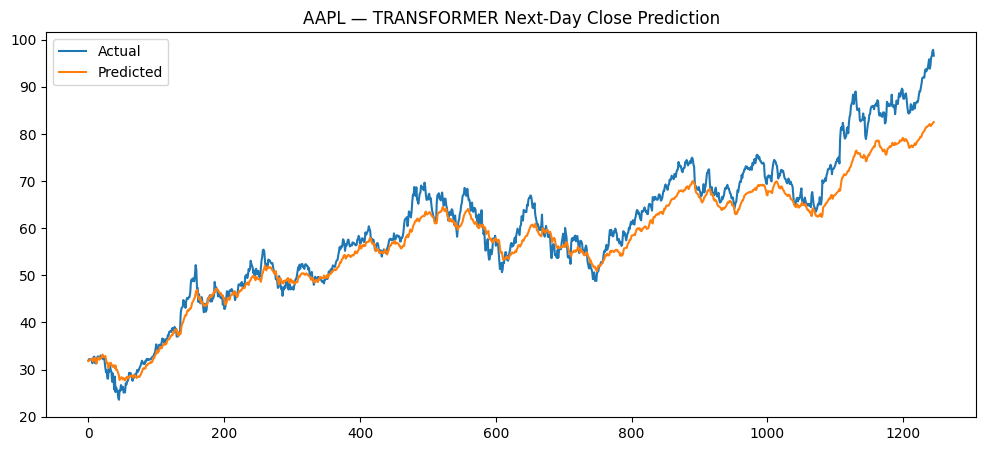

----- BACKTEST RESULTS -----
Total Return: -1.0
Win Rate: 0.19020866773675763


In [25]:
"""
This cell builds a full single-ticker stock-prediction pipeline using a
Transformer model. It downloads AAPL data, engineers technical indicators,
creates 40-day sequences, and trains a Transformer to predict next-day close.
Finally, it visualizes predictions and runs a simple long/short backtest.
"""
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# DOWNLOAD DATA

TICKER = "AAPL"
START = "2000-01-01"
END   = "2024-12-31"

df = yf.download(TICKER, start=START, end=END, auto_adjust=False)

# FIX MULTIINDEX COLUMNS
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]  # extract ("Close","AAPL") -> "Close"

# Now df has: Open, High, Low, Close, Volume
print(df.head())
print("Columns:", df.columns)

df = df[["Open","High","Low","Close","Volume"]].copy()
df.dropna(inplace=True)
print("Data loaded:", df.shape)

# ADD TECHNICAL INDICATORS

def add_indicators(df):
    df = df.copy()

    # Moving averages
    df["ma5"]  = df["Close"].rolling(5).mean()
    df["ma10"] = df["Close"].rolling(10).mean()
    df["ma20"] = df["Close"].rolling(20).mean()

    # Momentum
    df["mom5"]  = df["Close"].pct_change(5)
    df["mom10"] = df["Close"].pct_change(10)

    # Volatility
    df["vol5"] = df["Close"].pct_change().rolling(5).std()
    df["vol10"] = df["Close"].pct_change().rolling(10).std()

    # RSI
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-9)
    df["rsi14"] = 100 - (100 / (1 + rs))

    df.dropna(inplace=True)
    return df

df = add_indicators(df)
print("After indicators:", df.shape)

# PREPARE SEQUENCES

SEQ_LEN = 40  # lookback window

FEATURES = df.columns.tolist()
num_features = len(FEATURES)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

X = []
y = []

close_idx = df.columns.tolist().index("Close")

for i in range(len(scaled) - SEQ_LEN - 1):
    X.append(scaled[i:i+SEQ_LEN])
    y.append(scaled[i+SEQ_LEN][close_idx])  # predict next-day close

X = np.array(X)
y = np.array(y)

# Train/Test Split
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test,  y_test  = X[train_size:], y[train_size:]

print("Train shapes:", X_train.shape, y_train.shape)

# PYTORCH DATASET
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PriceDataset(X_train, y_train)
test_ds  = PriceDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# TRANSFORMER MODEL FOR STOCK PREDICTION
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerModel(nn.Module):
    def __init__(self, feature_dim, hidden=64, num_layers=2, num_heads=4):
        super().__init__()

        self.input_layer = nn.Linear(feature_dim, hidden)
        self.positional_encoding = PositionalEncoding(hidden)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden,
            nhead=num_heads,
            dim_feedforward=hidden * 4,
            dropout=0.1,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = x[:, -1]       # last token
        x = self.fc_out(x)
        return x.squeeze()


model = TransformerModel(
    feature_dim=num_features,
    hidden=64,
    num_layers=2,
    num_heads=4
).to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# TRAINING LOOP

EPOCHS = 20
print("Training..")

for epoch in range(EPOCHS):
    model.train()
    losses = []

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {np.mean(losses):.6f}")

# PREDICTION
model.eval()
preds = []
actual = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb).cpu().numpy()
        preds.extend(out)
        actual.extend(yb.numpy())

# Invert scaling
actual_prices = scaler.inverse_transform(
    np.column_stack([np.zeros((len(actual), num_features-1)), actual])
)[:,-1]

pred_prices = scaler.inverse_transform(
    np.column_stack([np.zeros((len(preds), num_features-1)), preds])
)[:,-1]

# PLOT RESULTS

plt.figure(figsize=(12,5))
plt.plot(actual_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{TICKER} — TRANSFORMER Next-Day Close Prediction")
plt.legend()
plt.show()

# BACKTEST
returns = (pd.Series(pred_prices).shift(1) - pd.Series(actual_prices)) / pd.Series(actual_prices)
total_return = (1 + returns.fillna(0)).prod() - 1
win_rate = (returns > 0).mean()

print("----- BACKTEST RESULTS -----")
print("Total Return:", total_return)
print("Win Rate:", win_rate)


Device: cuda
Raw rows: 7786
After indicators: (7766, 19)
After adding target: (7765, 20)
Features used: ['ret1', 'ma5_ratio', 'ma20_ratio', 'mom5', 'mom10', 'vol10', 'vol20', 'rsi14', 'atr14', 'bb_width', 'obv']
Sequences: (7705, 60, 11) (7705,)
Split sizes (train,val,test): 5393 1156 1156
Training...
Epoch 001 | train 2.282141e-03 | val 4.106862e-04 | time 0.4s
Epoch 002 | train 2.439205e-04 | val 3.198091e-04 | time 0.3s
Epoch 003 | train 2.068041e-04 | val 2.657963e-04 | time 0.3s
Epoch 004 | train 1.950925e-04 | val 2.559087e-04 | time 0.3s
Epoch 005 | train 1.914575e-04 | val 1.922079e-04 | time 0.3s
Epoch 006 | train 1.816858e-04 | val 2.369940e-04 | time 0.3s
Epoch 007 | train 1.851261e-04 | val 1.676329e-04 | time 0.3s
Epoch 008 | train 1.883780e-04 | val 1.910823e-04 | time 0.3s
Epoch 009 | train 1.758676e-04 | val 1.655086e-04 | time 0.4s
Epoch 010 | train 1.847642e-04 | val 1.645734e-04 | time 0.3s
Epoch 011 | train 1.807823e-04 | val 1.252273e-04 | time 0.3s
Epoch 012 | tra

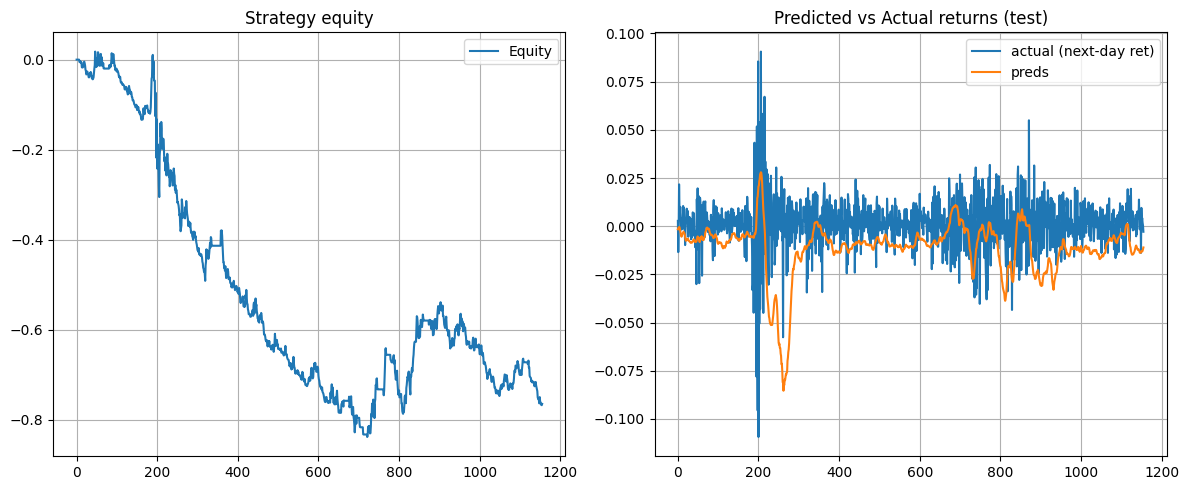

Saved transformer_medium_backtest.csv


In [26]:
"""
This cell implements a medium-complexity Transformer model for quantitative
return forecasting on SPY. It enriches the data with advanced technical
indicators, predicts next-day returns using a Transformer encoder, and runs a
transaction-cost-adjusted backtest producing Sharpe, drawdown, and equity curves.
"""

import math, time, random
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# CONFIG
TICKER = "SPY"
START = "1990-01-01"
END   = "2024-01-01"

SEQ_LEN = 60                # lookback window
BATCH = 128
EPOCHS = 80
LR = 2e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

TCOST = 0.0005              # transaction cost per trade (0.05%)
POSITION_THRESHOLD_STD = 0.25  # threshold as fraction of preds std
VOL_TARGET = False          # if True, scale positions by target volatility

print("Device:", DEVICE)

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# HELPERS: indicators, backtest
def add_indicators(df):
    df = df.copy()
    df["ret1"] = df["Close"].pct_change()
    # moving averages and ratios
    df["ma5"] = df["Close"].rolling(5).mean()
    df["ma10"] = df["Close"].rolling(10).mean()
    df["ma20"] = df["Close"].rolling(20).mean()
    df["ma5_ratio"] = df["Close"] / (df["ma5"] + 1e-9) - 1
    df["ma20_ratio"] = df["Close"] / (df["ma20"] + 1e-9) - 1
    # momentum
    df["mom5"] = df["Close"].pct_change(5)
    df["mom10"] = df["Close"].pct_change(10)
    # rolling vol
    df["vol10"] = df["ret1"].rolling(10).std()
    df["vol20"] = df["ret1"].rolling(20).std()
    # RSI 14
    delta = df["Close"].diff()
    up = delta.clip(lower=0).rolling(14).mean()
    down = -delta.clip(upper=0).rolling(14).mean()
    rs = up / (down + 1e-9)
    df["rsi14"] = 100 - (100 / (1 + rs))
    # ATR 14
    hl = df["High"] - df["Low"]
    hc = (df["High"] - df["Close"].shift(1)).abs()
    lc = (df["Low"] - df["Close"].shift(1)).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    df["atr14"] = tr.rolling(14).mean()
    # Bollinger width (20,2)
    ma20 = df["Close"].rolling(20).mean()
    sd20 = df["Close"].rolling(20).std()
    df["bb_width"] = (ma20 + 2*sd20 - (ma20 - 2*sd20)) / (ma20 + 1e-9)
    # OBV
    obv = (np.sign(df["Close"].diff()) * df["Volume"]).fillna(0).cumsum()
    df["obv"] = obv
    # dropna
    df = df.dropna().reset_index(drop=True)
    return df

def compute_sharpe(returns, freq=252.0):
    mean = returns.mean(); std = returns.std()
    if std == 0 or np.isnan(std): return np.nan
    return np.sqrt(freq) * (mean / std)

def max_drawdown(equity):
    roll_max = np.maximum.accumulate(equity)
    dd = (equity - roll_max) / (roll_max + 1e-18)
    return dd.min()

def backtest_from_preds(preds, rets, threshold_scale=POSITION_THRESHOLD_STD, cost=TCOST, vol_target=False):
    preds = np.array(preds)
    rets = np.array(rets)
    if len(preds) != len(rets):
        n = min(len(preds), len(rets))
        preds = preds[:n]; rets = rets[:n]
    # threshold based on preds std
    s = preds.std() if preds.std() > 0 else 1.0
    thr = threshold_scale * s
    # position: sign with deadband
    pos = np.where(preds > thr, 1.0, np.where(preds < -thr, -1.0, 0.0))
    if vol_target:
        realized_vol = pd.Series(rets).rolling(21).std().fillna(rets.std())
        target_vol = realized_vol.median()
        scale = target_vol / (realized_vol + 1e-9)
        pos = pos * scale.values
        # clip
        pos = np.clip(pos, -2.0, 2.0)
    # transaction costs on position changes
    pos_change = np.abs(np.diff(pos, prepend=0.0))
    tc = pos_change * cost
    # daily pnl (returns are next-day returns)
    daily_pnl = pos * rets - tc
    equity = np.cumsum(daily_pnl)
    sharpe = compute_sharpe(daily_pnl)
    mdd = max_drawdown(equity)
    win_rate = np.mean(daily_pnl > 0)
    return dict(pos=pos, pnl=daily_pnl, equity=equity, sharpe=sharpe, mdd=mdd, win_rate=win_rate, thr=thr)

# DOWNLOAD & PREPARE DATA
print("Downloading", TICKER)
df = yf.download(TICKER, start=START, end=END, progress=False)

# Flatten MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]

# ensure essential columns present
df = df[["Open","High","Low","Close","Volume"]].dropna().reset_index(drop=True)
print("Raw rows:", len(df))

# indicators
df = add_indicators(df)
print("After indicators:", df.shape)

# target: next-day return (Close[t+1]/Close[t] - 1)
df["target"] = df["Close"].pct_change().shift(-1)
df = df.dropna().reset_index(drop=True)
print("After adding target:", df.shape)

FEATURE_COLS = ["ret1", "ma5_ratio", "ma20_ratio", "mom5", "mom10",
                "vol10", "vol20", "rsi14", "atr14", "bb_width", "obv"]
# ensure all exist
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print("Features used:", FEATURE_COLS)

# build sequences
Xs = []
ys = []
dates = []
for i in range(SEQ_LEN, len(df)-0):
    Xs.append(df.loc[i-SEQ_LEN:i-1, FEATURE_COLS].values)
    ys.append(df.loc[i, "target"])
    dates.append(df.index[i])
Xs = np.array(Xs)   # shape (N, SEQ_LEN, n_features)
ys = np.array(ys)
dates = np.array(dates)
print("Sequences:", Xs.shape, ys.shape)

# train/val/test split by time
n = len(Xs)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = Xs[:train_end], ys[:train_end]
X_val, y_val     = Xs[train_end:val_end], ys[train_end:val_end]
X_test, y_test   = Xs[val_end:], ys[val_end:]
dates_test = dates[val_end:]

print("Split sizes (train,val,test):", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# scale features
n_feats = X_train.shape[2]
scaler = RobustScaler()
X_train_flat = X_train.reshape(-1, n_feats)
scaler.fit(X_train_flat)
X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, n_feats)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, n_feats)).reshape(X_test.shape)

# PyTorch Dataset & Model
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
val_ds = SeqDataset(X_val, y_val)
test_ds = SeqDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

# Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2, 1))
    def forward(self, x):
        # x: (batch, seq_len, n_features)
        x = self.input_proj(x)
        x = self.pos(x)
        x = self.transformer(x)
        x = x.mean(dim=1)   # simple pooling
        out = self.head(x).squeeze(-1)
        return out

model = TransformerRegressor(n_features=n_feats, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
criterion = nn.MSELoss()

# TRAIN
best_val = float("inf")
patience = 10
pat = 0
print("Training...")
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # val
    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
            val_losses.append(criterion(model(Xb), yb).item())
    train_loss = np.mean(train_losses) if train_losses else 0.0
    val_loss = np.mean(val_losses) if val_losses else 0.0
    print(f"Epoch {epoch:03d} | train {train_loss:.6e} | val {val_loss:.6e} | time {time.time()-t0:.1f}s")
    if val_loss < best_val - 1e-9:
        best_val = val_loss; pat = 0
        torch.save(model.state_dict(), "best_transformer_medium.pt")
    else:
        pat += 1
        if pat >= patience:
            print("Early stopping.")
            break

# load best
if Path("best_transformer_medium.pt").exists():
    model.load_state_dict(torch.load("best_transformer_medium.pt", map_location=DEVICE))

# PREDICT on test
model.eval()
preds = []
actual = []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(DEVICE)
        p = model(Xb).cpu().numpy()
        preds.extend(p.tolist())
        actual.extend(yb.numpy().tolist())
preds = np.array(preds); actual = np.array(actual)
print("Test samples:", len(preds))


# BACKTEST & METRICS
res = backtest_from_preds(preds, actual, threshold_scale=POSITION_THRESHOLD_STD, cost=TCOST, vol_target=VOL_TARGET)
print("\nBACKTEST SUMMARY")
print("Sharpe:", res["sharpe"])
print("Max Drawdown:", res["mdd"])
print("Total Return:", res["equity"][-1] if len(res["equity"])>0 else 0.0)
print("Win Rate:", res["win_rate"], "Threshold used:", res["thr"])


# PLOT equity & preds vs actual
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(res["equity"], label="Equity")
plt.title("Strategy equity")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(actual, label="actual (next-day ret)")
plt.plot(preds, label="preds")
plt.title("Predicted vs Actual returns (test)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# SAVE CSV
out = pd.DataFrame({
    "date_idx": dates_test,
    "pred": preds,
    "actual": actual,
    "position": res["pos"],
    "pnl": res["pnl"],
    "equity": res["equity"]
})
out.to_csv("transformer_medium_backtest.csv", index=False)
print("Saved transformer_medium_backtest.csv")


In [28]:
"""
This cell builds a Transformer-based classifier that predicts whether the next
day’s return is UP or DOWN. It prepares sequences of standardized features,
trains a Transformer encoder for binary classification, and converts predicted
probabilities into long/short trading signals for a simple backtest.
"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEQ_LEN = 40   # number of past days per sample

#TARGET: Predict UP/DOWN
df["return"] = df["Close"].pct_change()
df["target_bin"] = (df["return"] > 0).astype(int)
df = df.dropna().reset_index(drop=True)

# KEEP ONLY FEATURE COLUMNS
FEATURE_COLS = [
    c for c in df.columns
    if c not in ["return", "target_bin", "target"]
]
FEATURES = len(FEATURE_COLS)
print("Using features:", FEATURES, FEATURE_COLS)

# SEQUENCE CREATION
# Scale the feature columns
scaler = StandardScaler()
scaled = scaler.fit_transform(df[FEATURE_COLS])

X, y = [], []
for i in range(len(scaled) - SEQ_LEN - 1):
    X.append(scaled[i:i+SEQ_LEN, :])     # shape: (40, FEATURES)
    y.append(df["target_bin"].iloc[i+SEQ_LEN])

X = np.array(X, dtype=np.float32)        # shape: (N, 40, FEATURES)
y = np.array(y, dtype=np.int64)

print("X.shape:", X.shape)
print("y.shape:", y.shape)

# Train / Test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]
print("Train:", X_train.shape, "Test:", X_test.shape)


# TRANSFORMER CLASSIFIER MODEL
class TransformerClassifier(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=3, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(FEATURES, d_model)

        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 2)  # 2 classes UP/DOWN

    def forward(self, x):
        x = self.input_proj(x)      # -> (batch, 40, d_model)
        x = self.transformer(x)     # -> transformer output
        x = x.mean(dim=1)           # global average pooling
        return self.fc(x)           # logits


model = TransformerClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)


# TRAIN LOOP
train_data = torch.utils.data.TensorDataset(
    torch.tensor(X_train), torch.tensor(y_train)
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.6f}")


#PREDICT PROBABILITIES
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test).to(DEVICE))
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # prob UP


# BACKTEST (classification-based long/short)

threshold = 0.55
preds = (probs > threshold).astype(int)

rets = df["return"].iloc[SEQ_LEN + split:].values

strategy_ret = []
for p, r in zip(preds, rets):
    if p == 1:      # predict UP → long
        strategy_ret.append(r)
    else:           # predict DOWN → short
        strategy_ret.append(-r)

strategy_ret = np.array(strategy_ret)

total_return = strategy_ret.sum()
win_rate = (strategy_ret > 0).mean()
print("\n")
print("CLASSIFICATION BACKTEST ")
print("Total Return:", total_return)
print("Win Rate:", win_rate)


Device: cuda
Using features: 19 ['Open', 'High', 'Low', 'Close', 'Volume', 'ret1', 'ma5', 'ma10', 'ma20', 'ma5_ratio', 'ma20_ratio', 'mom5', 'mom10', 'vol10', 'vol20', 'rsi14', 'atr14', 'bb_width', 'obv']
X.shape: (7722, 40, 19)
y.shape: (7722,)
Train: (6177, 40, 19) Test: (1545, 40, 19)
Epoch 1/40 - Loss: 0.697648
Epoch 2/40 - Loss: 0.694694
Epoch 3/40 - Loss: 0.690997
Epoch 4/40 - Loss: 0.691873
Epoch 5/40 - Loss: 0.690260
Epoch 6/40 - Loss: 0.691484
Epoch 7/40 - Loss: 0.691417
Epoch 8/40 - Loss: 0.691175
Epoch 9/40 - Loss: 0.690597
Epoch 10/40 - Loss: 0.691114
Epoch 11/40 - Loss: 0.690518
Epoch 12/40 - Loss: 0.690843
Epoch 13/40 - Loss: 0.690233
Epoch 14/40 - Loss: 0.690290
Epoch 15/40 - Loss: 0.690197
Epoch 16/40 - Loss: 0.689556
Epoch 17/40 - Loss: 0.689864
Epoch 18/40 - Loss: 0.690244
Epoch 19/40 - Loss: 0.690310
Epoch 20/40 - Loss: 0.689983
Epoch 21/40 - Loss: 0.689561
Epoch 22/40 - Loss: 0.689545
Epoch 23/40 - Loss: 0.689104
Epoch 24/40 - Loss: 0.689712
Epoch 25/40 - Loss: 0.68